**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm为例) 

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna() 
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 194.46356987953186


RET1_1    RET2_1    RET1_2    RET2_2    RET1_3  \
datetime   instrument                                                     
2006-04-13 000001.SZ   0.018127  0.237705  0.045317  0.573770  0.018127   
           000002.SZ   0.034109  0.467213  0.066667  0.790984  0.040310   
           000059.SZ   0.037037  0.532787  0.049383  0.618852  0.071605   
           000061.SZ   0.039855  0.586066  0.005435  0.184426  0.007246   
           000063.SZ   0.003007  0.163934  0.012028  0.225410  0.020047   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.014707  0.757895 -0.044489  0.070175 -0.045297   
           688396.SH   0.013962  0.736842 -0.000566  0.585965 -0.009623   
           688561.SH   0.021935  0.877193  0.031379  0.954386  0.023001   
           688599.SH  -0.038425  0.010526 -0.053571  0.042105 -0.140784   
           688981.SH   0.014181  0.747368  0.012958  0.817544  0.003912   

                         RET2_3    RET1_4    RET2_4    CLOSE5   ROC5  ...  \
datetime   instrument                                                 ...   
2006-04-13 000001.SZ   0.336066 -0.022659  0.213115  0.984894 -0.180  ...   
           000002.SZ   0.557377  0.058915  0.819672  1.080620 -0.304  ...   
           000059.SZ   0.815574  0.059259  0.823770  1.027160 -0.222  ...   
           000061.SZ   0.245902  0.009058  0.495902  0.972826 -0.170  ...   
           000063.SZ   0.352459  0.051788  0.778689  1.094220 -0.764  ...   
...                         ...       ...       ...       ...    ...  ...   
2022-12-28 688363.SH   0.122807 -0.038973  0.136842  0.913302  2.158  ...   
           688396.SH   0.487719  0.012264  0.828070  1.014528 -0.354  ...   
           688561.SH   0.950877 -0.051028  0.091228  0.938309  0.610  ...   
           688599.SH   0.007018 -0.116550  0.007018  0.855389  1.614  ...   
           688981.SH   0.757895  0.004156  0.719298  1.009535 -0.278  ...   

                       CORRCV10  CORRCV20  CORRCV30  CORRCV60   AMOUNT5  \
datetime   instrument                                                     
2006-04-13 000001.SZ  -1.104650 -1.249570 -1.463733 -1.044095  1.139074   
           000002.SZ  -0.217854 -0.440808 -0.281896 -0.243158  1.194574   
           000059.SZ   0.143769 -0.016791  0.110390  0.163974  1.498461   
           000061.SZ  -0.075133  0.112249  0.248279  0.253330  1.844614   
           000063.SZ  -0.054157 -0.104096  0.037435  0.053793  1.177229   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH  -1.365902 -1.637625 -1.760224 -1.811791  0.391778   
           688396.SH   0.422790  0.124940  0.174181  0.082891  1.674625   
           688561.SH  -1.241557 -1.704082 -2.131163 -2.025677  0.494056   
           688599.SH  -1.414989 -0.806515 -1.176738 -1.453161  0.528563   
           688981.SH   0.307370  0.032351  0.064034  0.025123  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-04-13 000001.SZ   0.808621  0.471296  1.349543  1.307721 -0.4400  
           000002.SZ   1.446053  0.678715  0.604166  0.639505 -3.3300  
           000059.SZ   0.615724  0.197315  0.494023  1.417788 -0.4900  
           000061.SZ   0.387233  0.135996  0.205245  0.213659  3.3700  
           000063.SZ   1.163405  0.458922  0.409041  0.469591 -7.4200  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1137622 rows x 159 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1137622 entries, (Timestamp('2006-04-13 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 159 entries, RET1_1 to label
dtypes: float64(159)
memory usage: 1.4+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


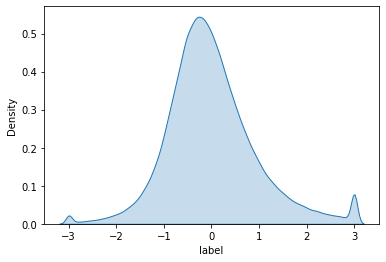

The distribution of y_valid:


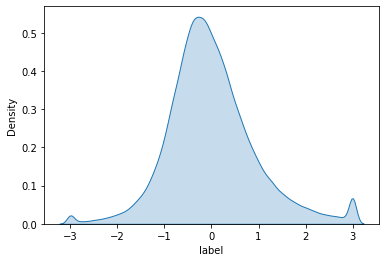

The distribution of y_test:


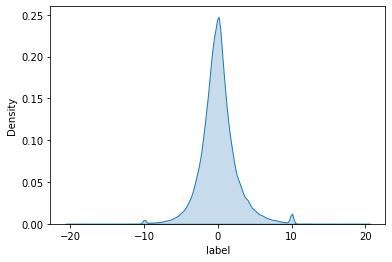

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "group_split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}
# 按split_params拆分出训练集、验证集和测试集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
# 查看数据处理的结果
X_train.describe()

,RET1_1,RET2_1,RET1_2,RET2_2,RET1_3,RET2_3,RET1_4,RET2_4,CLOSE5,ROC5,...,CORRCV5,CORRCV10,CORRCV20,CORRCV30,CORRCV60,AMOUNT5,AMOUNT10,AMOUNT20,AMOUNT30,AMOUNT60
count,600346.000000,6.003460e+05,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,...,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000,600346.000000
mean,-0.001748,2.090224e-05,-0.007268,0.000015,-0.010271,0.000017,-0.012195,0.000019,-0.013553,0.002988,...,0.007662,-0.001319,0.001866,0.005729,0.010925,-0.021095,-0.023730,-0.026736,-0.028038,-0.030142
std,0.895682,9.981878e-01,0.874924,0.998191,0.864285,0.998194,0.859465,0.998197,0.857239,0.754647,...,0.801543,0.958381,0.953836,0.924090,0.863929,0.881652,0.867086,0.849237,0.840161,0.829316
min,-3.000000,-1.894494e+00,-3.000000,-1.867469,-3.000000,-1.872661,-3.000000,-1.908121,-3.000000,-3.000000,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-2.591190,-2.326185,-2.081704,-1.824824
25%,-0.434104,-8.644987e-01,-0.433434,-0.864251,-0.432758,-0.863756,-0.436905,-0.864087,-0.440697,-0.307541,...,-0.431072,-0.610127,-0.464627,-0.390037,-0.301215,-0.600970,-0.597015,-0.589953,-0.583138,-0.576582
50%,0.052753,-3.839527e-16,0.023139,-0.000523,0.014719,-0.000602,0.009106,-0.000346,0.004716,-0.017055,...,-0.035059,0.019632,0.103626,0.127209,0.136990,-0.156693,-0.175899,-0.196684,-0.206680,-0.222075
75%,0.515398,8.644528e-01,0.476595,0.863789,0.457070,0.863594,0.449449,0.862990,0.445057,0.283027,...,0.435580,0.594847,0.554172,0.516776,0.458788,0.360938,0.334806,0.304012,0.279760,0.256813
max,3.000000,2.369545e+00,3.000000,2.878880,3.000000,2.391398,3.000000,2.573271,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [7]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid, early_stopping=50)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)  # 为防止数据泄露, 使用滞后2阶的mean和std还原预测值
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)
pred.describe()

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.880465	valid's l2: 0.881153
[40]	train's l2: 0.87775	valid's l2: 0.880243
[60]	train's l2: 0.875726	valid's l2: 0.879708
[80]	train's l2: 0.874021	valid's l2: 0.879308
[100]	train's l2: 0.872468	valid's l2: 0.879032
[120]	train's l2: 0.871007	valid's l2: 0.878767
[140]	train's l2: 0.869635	valid's l2: 0.878614
[160]	train's l2: 0.868372	valid's l2: 0.878496
[180]	train's l2: 0.867145	valid's l2: 0.878368
[200]	train's l2: 0.865878	valid's l2: 0.878246
[220]	train's l2: 0.864607	valid's l2: 0.878158
[240]	train's l2: 0.863403	valid's l2: 0.87808
[260]	train's l2: 0.862229	valid's l2: 0.878054
[280]	train's l2: 0.861178	valid's l2: 0.878011
[300]	train's l2: 0.860145	valid's l2: 0.877994
[320]	train's l2: 0.858968	valid's l2: 0.877995
[340]	train's l2: 0.857886	valid's l2: 0.877972
[360]	train's l2: 0.856957	valid's l2: 0.877953
[380]	train's l2: 0.85594	valid's l2: 0.877962
[400]	train's l2: 0.854983	valid's

,predict
count,280150.000000
mean,-0.000246
std,0.001553
min,-0.010859
25%,-0.001168
50%,-0.000194
75%,0.000729
max,0.007835


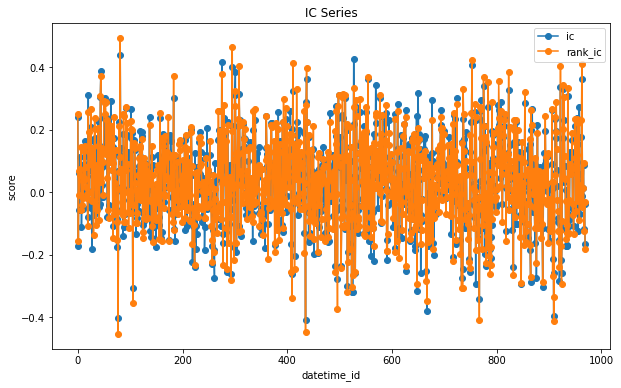

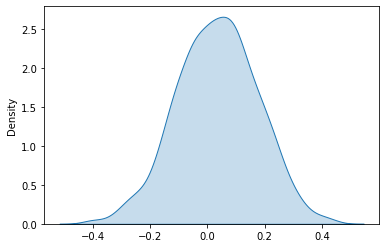

ic= 0.033267768695804806 icir= 0.2350994500627909 rank_ic= 0.035268438846644476 rank_icir= 0.24233293099109296


0.0297103695346776

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"], y_test)
r

In [9]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')

Accuracy of Prediction: 0.5283808134546079


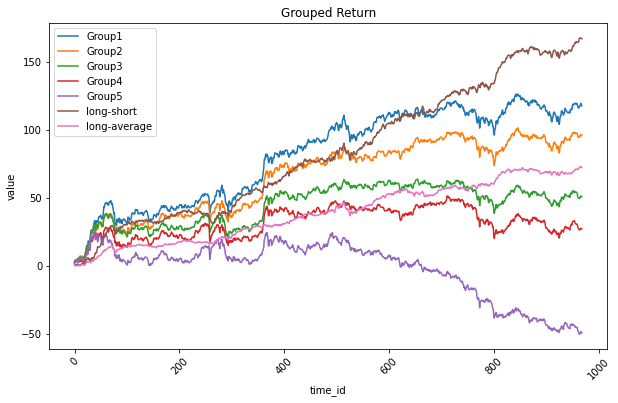

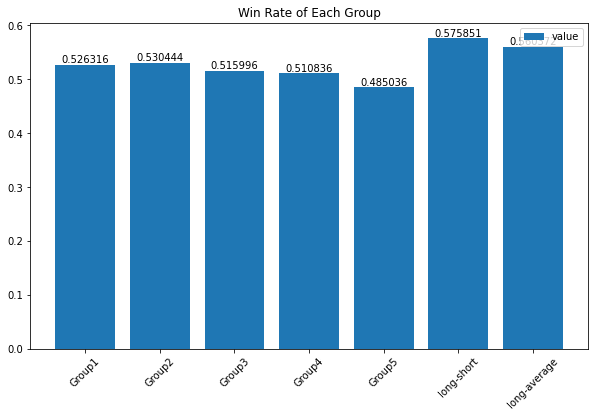

In [10]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

目前测得的策略容量以1亿(或者更少)为佳

In [11]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.25  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.12925893715942416
Annualized Volatility: 0.36231282300294104
Annualized Return(Benchmark): 0.07903465509941188
Annualized Volatility(Benchmark): 0.33918455897903593 

Cumulative Rate of Return: 0.5958928062779274
Cumulative Rate of Return(Benchmark): 0.3397659986073198
Cumulative Excess Rate of Return: 0.2561268076706076 

Max Drawdown: -0.3724707231694129
Max Drawdown(Benchmark): -0.5464988056952731
Max Drawdown(Excess Return): -0.1687282227540352 

Sharpe Ratio: 2.7447075836795367
Sortino Ratio: 0.3198821289718617
Information Ratio: 0.5008000050708057 

Beta: 1.0145519673314543
Alpha: 0.08649642713549621
Epsilon: 0.057812221631860394
Profitable Days(%): 0.9215686274509803


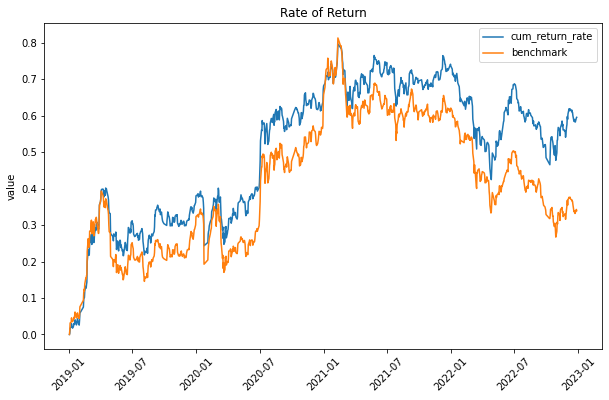

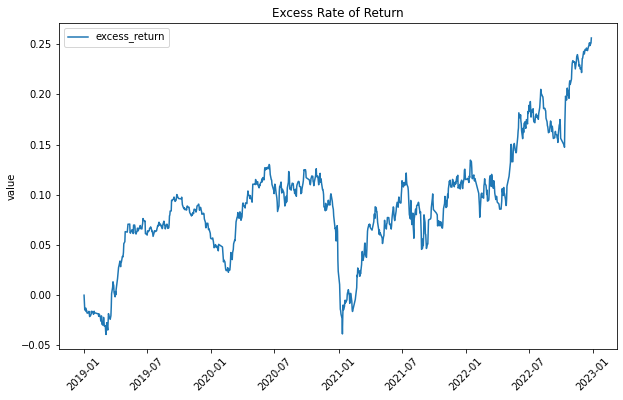

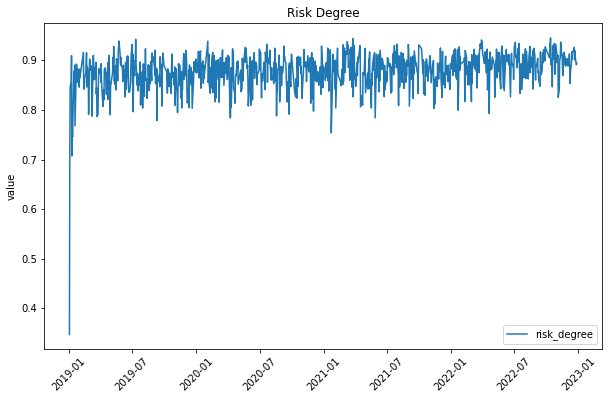

In [12]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
# user_account.buy_hist # 查看历史上所有买单